Package and Library

In [1]:
import sys, os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Load the data

In [2]:
current_path=os.getcwd()
loader_path=os.path.abspath(
    os.path.join(current_path, '..', 'disease_prediction','data',
        )
    )
sys.path.append(loader_path)
import datasets as ds
df=ds.load_datasets(
    subsets=['train', 'test', 'validate'],
    directory='../ddx-dataset/'
)
dp_data=pd.concat(
    [df['train'],df['test'],df['validate']],
    axis=0, 
    ignore_index=True
    )

In [3]:
# Features and labels
X=dp_data.drop('PATHOLOGY', axis=1)
y=dp_data['PATHOLOGY']

Label Encoding

In [4]:
label_encoder=LabelEncoder()
y_encoded=label_encoder.fit_transform(y)

Features Encoding

In [5]:
numerical_features=X.select_dtypes(include='int64').columns.tolist()
categorical_features=X.select_dtypes(include='object').columns.tolist()
features_preprocessor=ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numerical_features),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_features)
    ]
)

Split the Data

In [6]:
X_train, X_test, y_train, y_test=train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

Models

In [7]:
models={
    'Base: Logistic Regression': LogisticRegression(max_iter=1000,random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boost': GradientBoostingClassifier(random_state=42)
}

Perform KFold cross-validation

In [8]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)
cv_results={}
for name, model in models.items():
    pipeline=Pipeline(
        steps=[
            ('pre-processing',features_preprocessor),
            ('classifier',model)
        ]
    )
    cv_scores=cross_val_score(
        pipeline,X_train,y_train, cv=kf, scoring='accuracy'
        )
    cv_results[name]=cv_scores
    print(f"{name} Cross-Validation Accuracy Scores: {cv_results}")
    print(f"{name} Mean Accuracy: {cv_scores.mean()}")
    print(f"{name} Standard Deviation: {cv_scores.std()}")

Base: Logistic Regression Cross-Validation Accuracy Scores: {'Base: Logistic Regression': array([0.6024941 , 0.60467347, 0.59810601, 0.59928668, 0.60287787])}
Base: Logistic Regression Mean Accuracy: 0.6014876276271218
Base: Logistic Regression Standard Deviation: 0.002423833720280304
Random Forest Cross-Validation Accuracy Scores: {'Base: Logistic Regression': array([0.6024941 , 0.60467347, 0.59810601, 0.59928668, 0.60287787]), 'Random Forest': array([0.59250787, 0.59616283, 0.59092363, 0.59099742, 0.59355553])}
Random Forest Mean Accuracy: 0.592829455132845
Random Forest Standard Deviation: 0.001935487498853834
Gradient Boost Cross-Validation Accuracy Scores: {'Base: Logistic Regression': array([0.6024941 , 0.60467347, 0.59810601, 0.59928668, 0.60287787]), 'Random Forest': array([0.59250787, 0.59616283, 0.59092363, 0.59099742, 0.59355553]), 'Gradient Boost': array([0.60426505, 0.60506703, 0.59985242, 0.60041815, 0.60273029])}
Gradient Boost Mean Accuracy: 0.6024665882914617
Gradient 

Fit the models

In [13]:
final_results = {}
for name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ('pre-processing', features_preprocessor),
            ('classifier', model)
        ]
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    final_results[name] = {
        'accuracy': accuracy,  # Changed to lowercase 'a'
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }


Print the evaluation results

In [14]:
for name, results in final_results.items():
    print(f"\n{name} Final Model Accuracy: {results['accuracy']}")  # Accessing with lowercase 'a'
    print("Confusion Matrix:")
    print(results['confusion_matrix'])
    print("Classification Report:")
    print(results['classification_report'])


Base: Logistic Regression Final Model Accuracy: 0.6039944903581267
Confusion Matrix:
[[5335    0    0    0    0    1    0    0    0  874    0]
 [   0 3178    2    0 1482   14 1888   39  503   22    0]
 [   0   53  563    0  747   13  450    2  452   34    0]
 [   3    5    0   38   71    4    0   13   26   18    0]
 [   0  415    2    0 3727 1100  928   25  678  527    0]
 [ 672  183    0    0 2211 2223  869   25    4  592    0]
 [   0    4    0    0    0    0 7086    0   22    0    0]
 [   0  193    1    0  509   11  810  884  501   23    0]
 [   0   10    0    0   23    0 1471    8 3852   40    0]
 [ 218    9    0    0  720   28    0    4  573 2436    0]
 [   0    0    0    0    0    0    0    0    0    0 1373]]
Classification Report:
                         precision    recall  f1-score   support

     Allergic sinusitis       0.86      0.86      0.86      6210
            Anaphylaxis       0.78      0.45      0.57      7128
                 Chagas       0.99      0.24      0.39  

Plot the cross validation results

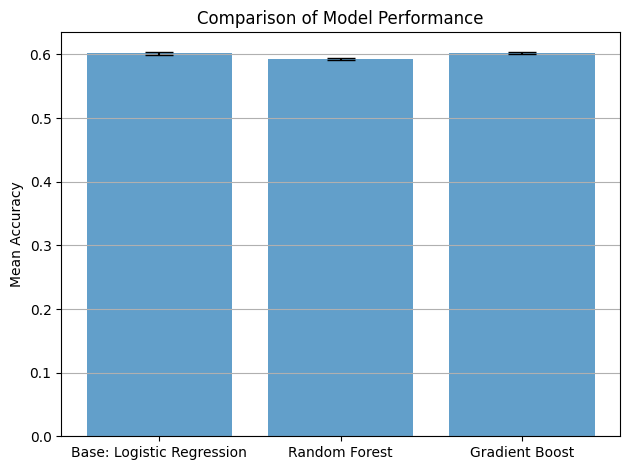

In [15]:
fig, ax = plt.subplots()
model_names = list(cv_results.keys())
cv_means = [cv_results[name].mean() for name in model_names]
cv_stds = [cv_results[name].std() for name in model_names]

x_pos = np.arange(len(model_names))
ax.bar(x_pos, cv_means, yerr=cv_stds, align='center', alpha=0.7, ecolor='black', capsize=10)
ax.set_ylabel('Mean Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names)
ax.set_title('Comparison of Model Performance')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()